In [1]:
import pandas as pd
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env, choose_backend,  backends, setup
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from IPython.display import display
from ipywidgets import widgets
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#!pip install --upgrade pip
#!pip install ipywidgets

In [63]:
df = pd.read_csv('Data/Competition.csv').drop_duplicates()

In [441]:
#UTILITIES
def strip_all_strings_in_df(df_, cols_):
    for s in cols_:
        df_[s] = df_[s].apply(lambda x: x.strip())
    return df_

#LOAD DATA
def get_competition_info(df_, div_='DI'):  
    df_ = get_teams_by_division(df_, div_)                                                      
    df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division', 'score'])     
    df_ = df_.groupby('compID') \
        .filter(lambda x: len(x) == 20) \
        .sort_values(['date', 'compID', 'position', 'result'], ascending=True) \
        .reset_index() \
        .iloc[:,1:]
    return df_

#GET TEAM INFO
def get_teams_by_division(df_, div_='DI'):
    df_ = df_[df_["division"] == div_].drop_duplicates() \
        .reset_index().iloc[:,1:] \
        .sort_values(sort_order, ascending=True)
    return df_

#SETTING RATINGS
def set_default_player_rating(df_, div_='DI'): 
    df_players_ = df_.loc[:, ['division',  'college', 'first_name', 'last_name', 'mu', 'sigma']].copy() \
                    .drop_duplicates()
    df_players_ = strip_all_strings_in_df(df_players_, ['division',  'college', 'first_name', 'last_name'])
    df_players_ = df_players_[df_players_.division == div_]
    df_players_.loc[:,'mu'] = Rating().mu
    df_players_['sigma'] = Rating().sigma
    df_players_ = df_players_.sort_values(['last_name', 'first_name', 'college'], ascending=True) \
        .drop_duplicates() \
        .reset_index() \
        .loc[:, ['division',  'college', 'first_name', 'last_name',  'mu', 'sigma']]
    return df_players_


#GETTING RATINGS
def get_player_ratings_from_match(df_, fname_, lname_, college_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def set_player_ratings_after_match(df_, fname_, lname_, college_, position_,k_factor_, rating_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu + k_factor_[int(position_)-1]
    #df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu
    df_.iloc[player_idx,  df_.columns.get_loc('sigma')] = rating_.sigma
    
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def create_ratings_from_matches(df_, k_factor_=[0,0,0,0,0], div_='DI'):
    df_matches = get_competition_info(df_, div_)
    df_players = set_default_player_rating(df_, div_)

    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

        hist_dict[counter] = df_matches.iloc[value].merge(df_players, \
                                                          left_on=['first_name', 'last_name', 'college'], 
                                                          right_on=['first_name', 'last_name', 'college'], 
                                                          how='inner')
        counter += 1

    df_match_history = pd.concat(hist_dict.values(), axis=0) \
                        .sort_values(['date','compID'], ascending=True) \
                        .reset_index() \
                        .iloc[:,1:] \
                        .rename(columns={'division_y': 'division'})
    df_match_history['name'] = df_match_history['first_name'] + " " + df_match_history['last_name']
    
    
    df_match_history = set_primary_position( df_match_history)
    
    d = {'matches': df_matches, 'match_history': df_match_history, 'players':  df_players}
    return d

def set_primary_position(df_):
    df_['count_max'] = df_.groupby(['college', 'name', 'position'])['position'].transform('count')
    df_['count at primary position'] = df_.groupby(['college','name'])['count_max'].transform('max')
    idx = df_[df_['count at primary position'] == df_['count_max']]

    #primary_position = strip_all_strings_in_df(primary_position, ['college','name'])
    primary_position = idx.loc[:, ['college','name', 'position']]
    primary_position['position'] = primary_position.groupby(['name'])['position'].transform('min')
    primary_position = primary_position.drop_duplicates()

    temp = df_.merge(primary_position, on=['college', 'name'])
    temp.rename(columns = {'position_y': 'primary position', 'position_x': 'position'}, inplace=True)
    temp = temp.loc[:,['date','compID', 'location', 'first_name', 'last_name', 'name', \
          'position', 'primary position', 'college','division' ,'result', 'mu', 'sigma' ]]
    return temp


def plot_rating_distribution(df_):
    d = df_ \
        .sort_values('date', ascending=True) \
        .groupby(['first_name', 'last_name', 'college']) \
        .last() \
        .sort_values('mu', ascending=False) \
        .reset_index()

    current_palette = sns.color_palette()

    f =  plt.figure(figsize=(30, 15))
    grid = plt.GridSpec(3, 5, wspace=.4, hspace=0.3)
    summary_ax = f.add_subplot(grid[:2, 0:])
    pos_ax = [f.add_subplot(grid[2, 4+(i*-1)], xticklabels=[], sharey=summary_ax) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=summary_ax,  color=current_palette[i], axlabel='Rating', hist_kws=dict(alpha=.1)) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=pos_ax[i], color=current_palette[i], axlabel='Position '+str(i+1))  for i in range(5)]
    return d

def get_top_players(df_, position_='all'):
    if position_ == 'all':
        df_top_players_ = df_.sort_values(['date', 'compID'], ascending=True).copy()
    else:
        df_top_players_ = df_[df_['primary position'] == position_].sort_values(['date', 'compID'], ascending=True).copy()
    df_top_players_ = df_top_players_.groupby(['first_name', 'last_name', 'college', 'division']) \
                                    .last() \
                                    .sort_values('mu', ascending=False) \
                                    .reset_index()
        
    df_top_players_['rank'] = df_top_players_.index+1
    df_top_players_ = df_top_players_.loc[:,['rank','name', 'college', 'division', 'mu', 'primary position', 'date']]
    df_top_players_.columns= ['rank','name', 'college', 'division', 'rating', 'primary position' ,'date']
    return df_top_players_


def compare_rank_to_avca_all_americans(df_):
    view = get_top_players(df_)
    view[view.name.isin([
                        "Torrey Van Winden",
                        "Tia Miric",
                        "Federica Frasca",
                        "Margherita Bianchin",
                        "Victoria Paranagua",
                        "Vanessa Freire",
                        "Claire Coppola",
                        "Kristen Nuss",
                        "Madeline Mertz",
                        "Kaylie Mchugh",
                        "Megan McNamara",
                        "Nicole McNamara",
                        "Emily Maglio",
                        "Ka'iwi Schucht",
                        "Abril Bustamante",
                        "Tina Graudina",
                        "Lily Justine",
                        "Sarah Sponcil",
                        "Deahna Kraft",
                        "Corinne Quiggle",
                        "Nele Barber",
                        "Molly Turner",
    ])]
    
def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    return df_summary

## No Spread Factor Applied

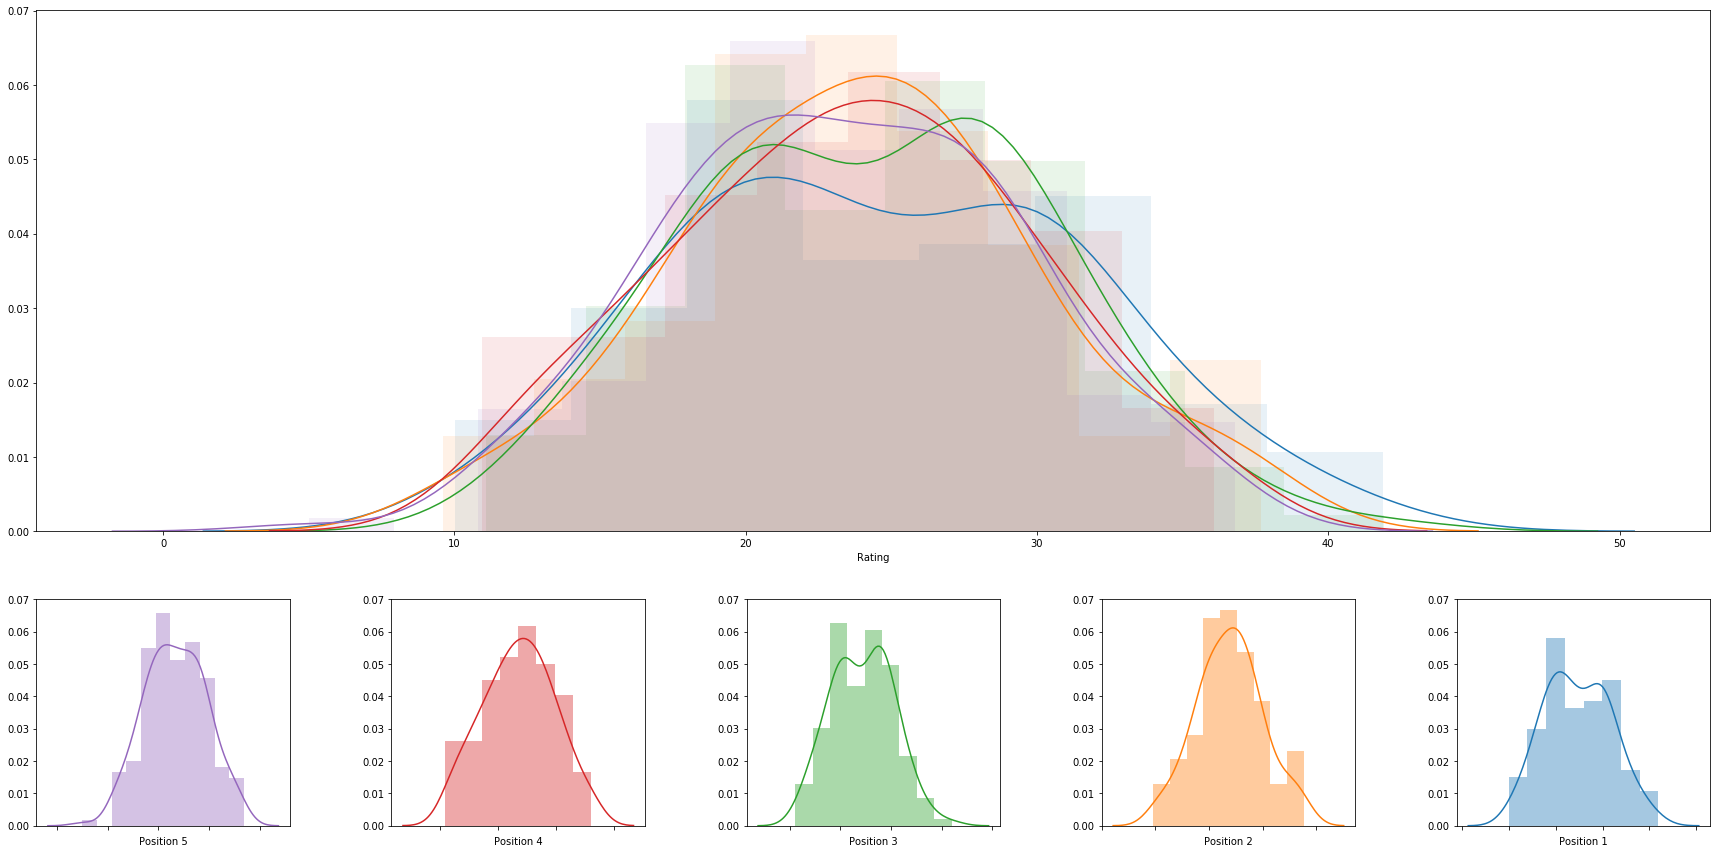

In [555]:
d = create_ratings_from_matches(df, [0,0,0,0, 0])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('000_000_000_000_000.csv')

## Introduce overlap - Mike's requested spread factor

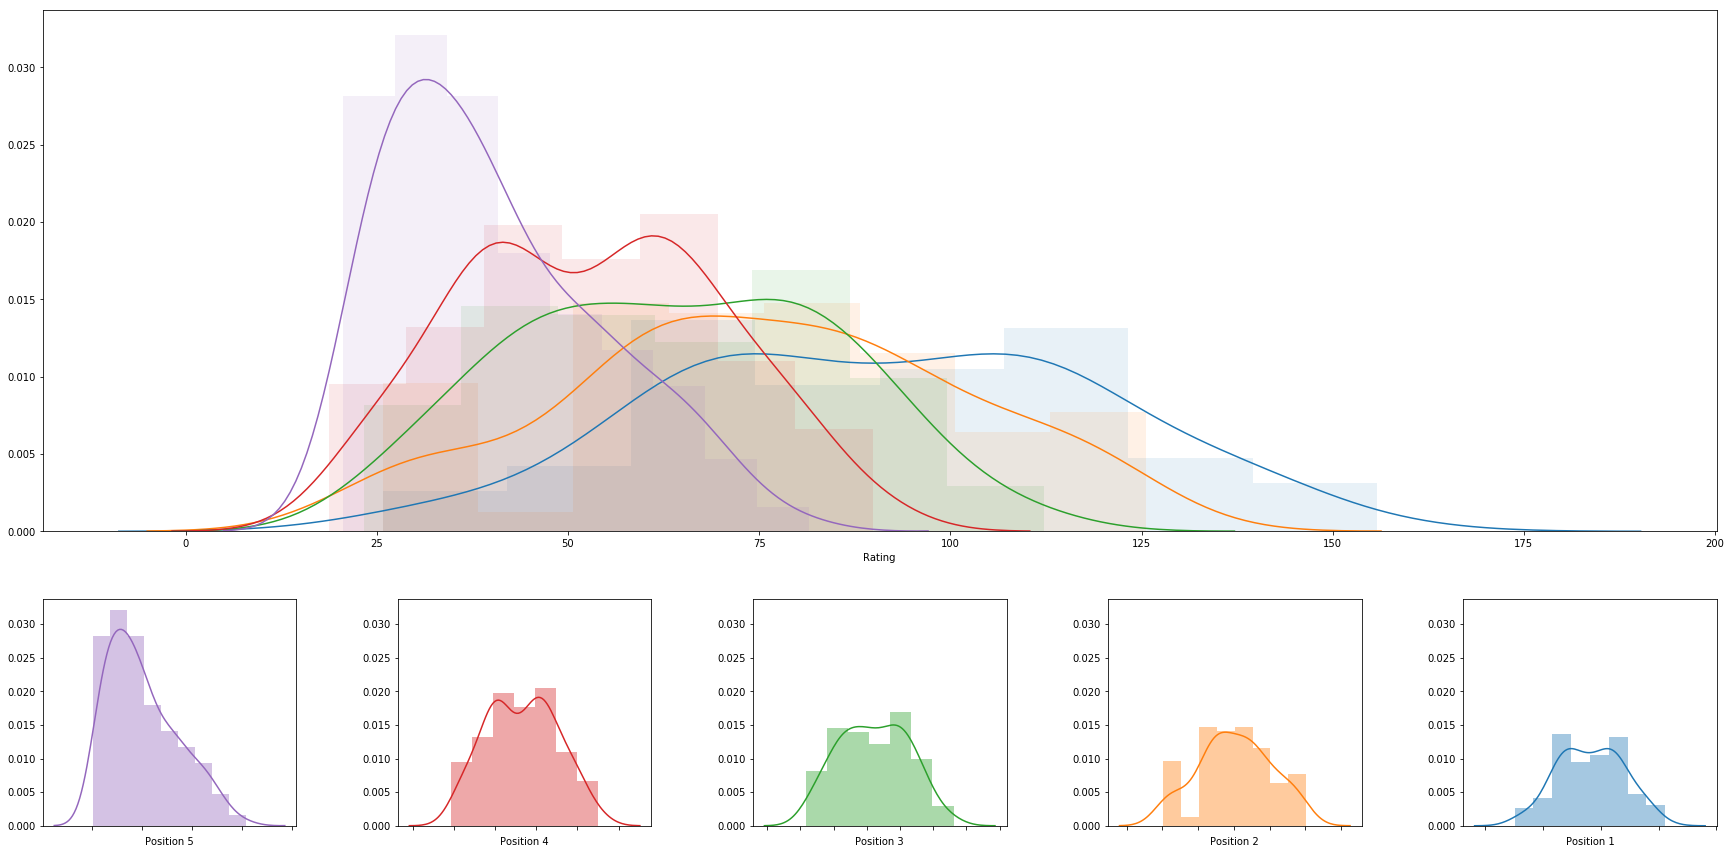

In [556]:
d = create_ratings_from_matches(df, [2.25, 1.7, 1.2, .75, .25])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('225_170_120_075_025.csv')

## Minimize spread factor, but keep overlap

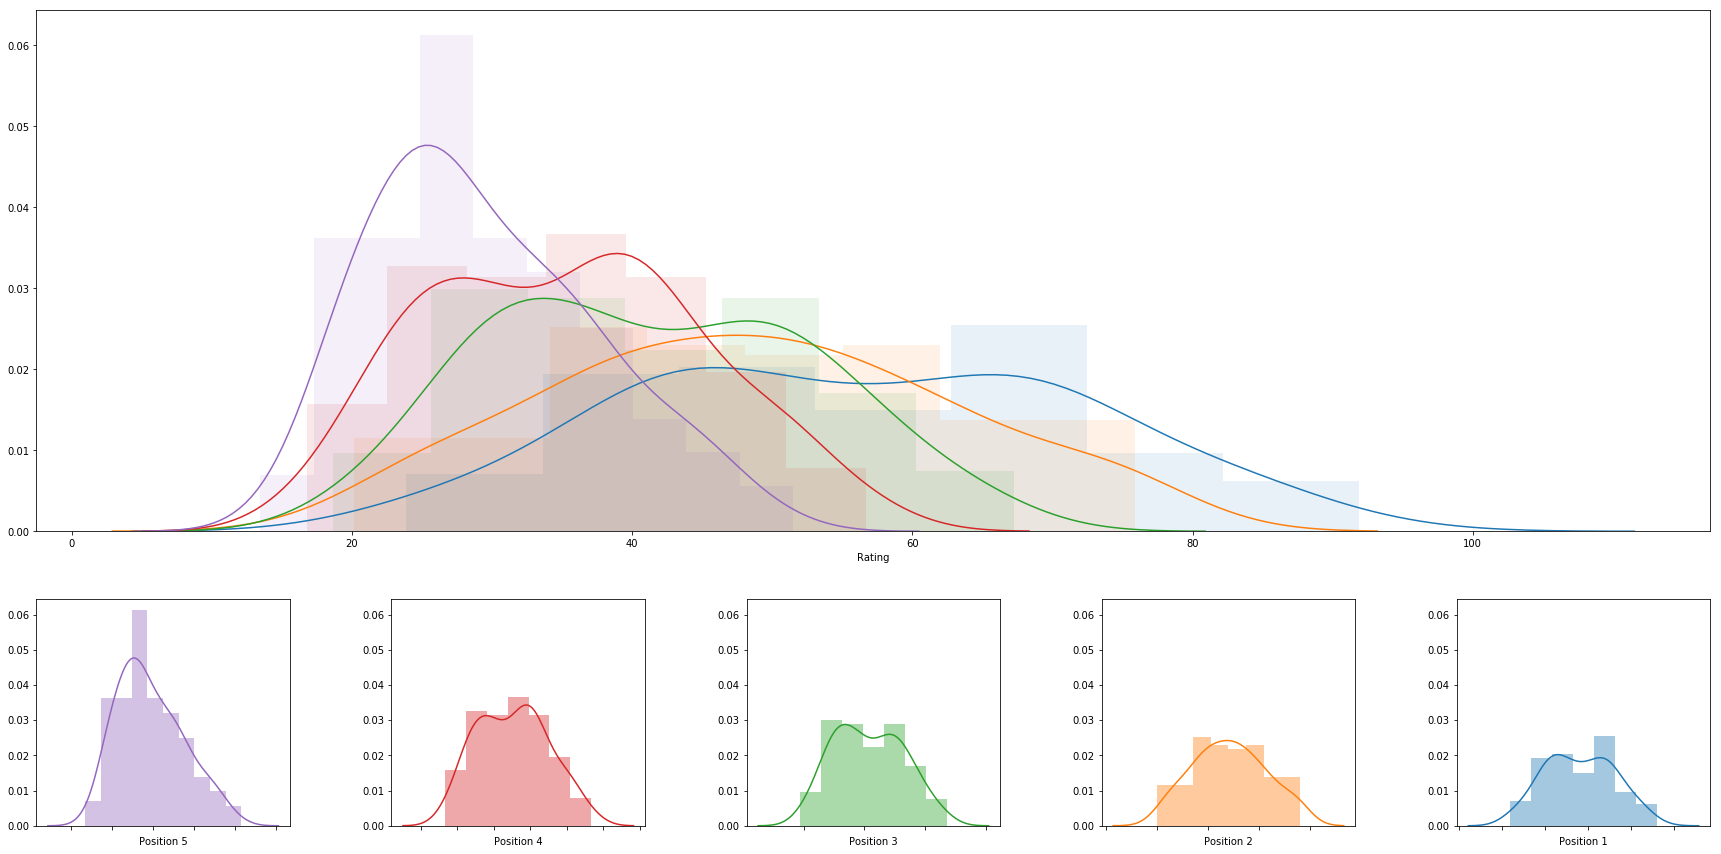

In [557]:
d = create_ratings_from_matches(df, [1.1, .9, .5, .3, 0])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('011_009_005_003_000.csv')

## Original Saturday night spread factor

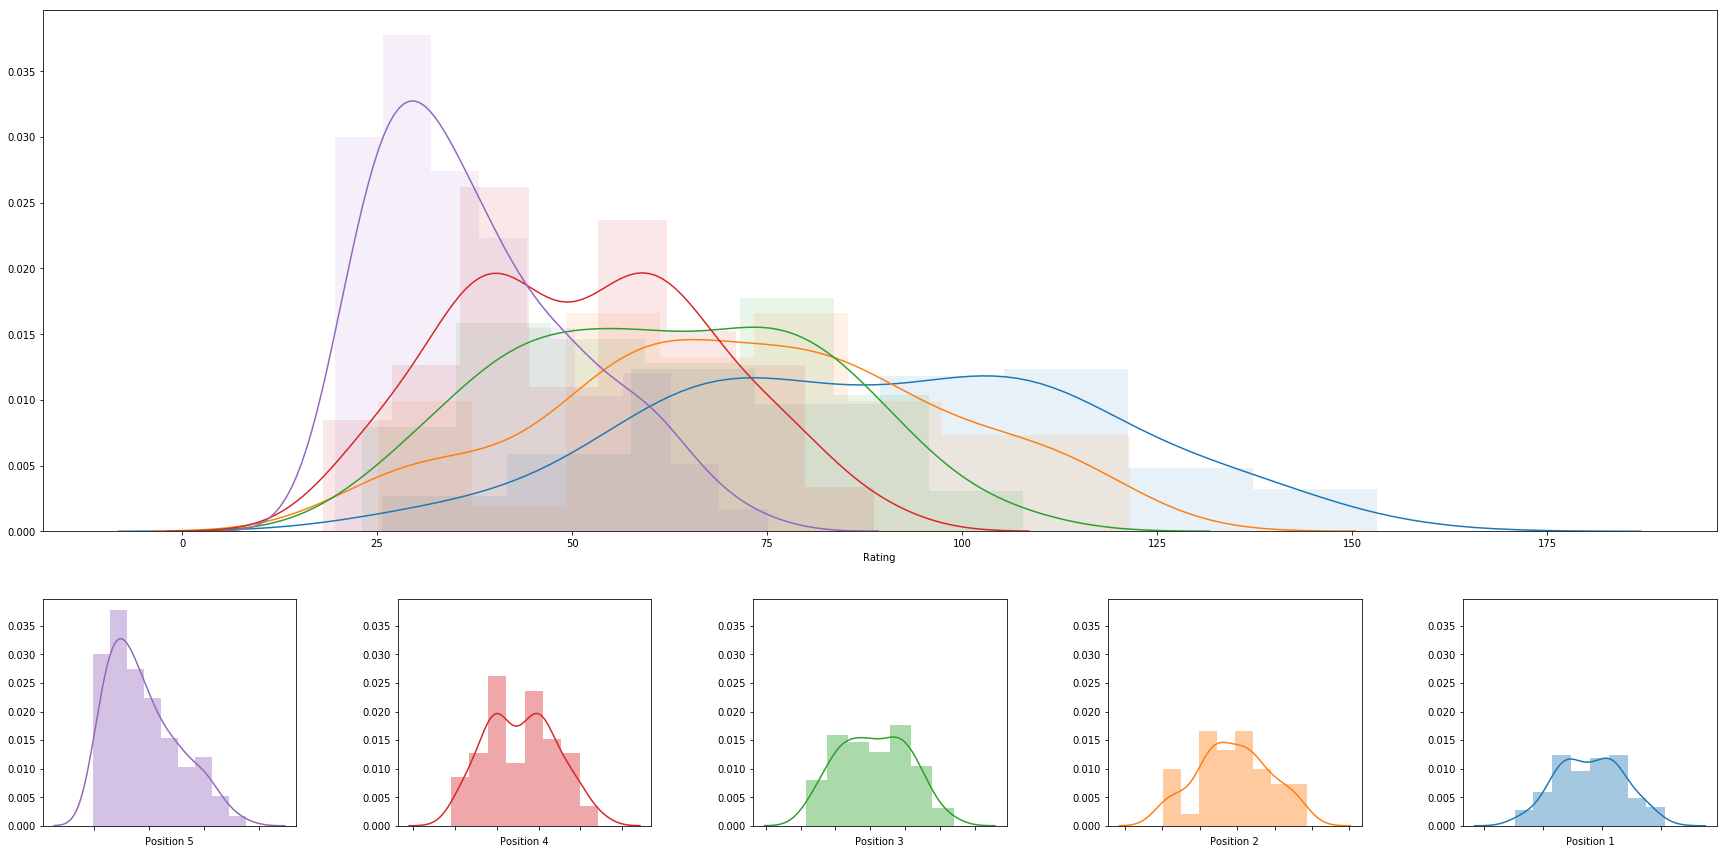

In [562]:
d = create_ratings_from_matches(df, [2.2, 1.5, 1.1, .75, 0])
rd = plot_rating_distribution(d['match_history'])
get_top_players(d['match_history'], position_='all').head(100).to_csv('220_150_110_075_000.csv')

### Factor logic
- Athletes who have never played in competition for the season, shouldn't show up in ranking. As soon as they compete in a match, their initial rating is 25
- Athletes who have a win/loss record of less than 500 may have ratings lower than players who have never played in competition
- A 2.3 factor will be added to matchup results for Position 1 players to ensure that even if a match is lost, it does not result in loss of rating points
- No factor will be added to matchup results for Position 5 players.
- The remaing factors for positions 2, 3 and 4 shall be determined by limiting the overlap of the top ~25% of players in the position

KATIE HORTON
College: Florida State
Division: DI
Primary Position: 2
Last Rating:111.34774959540408


/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma,Partner,Opponent 1,Opponent 2
0,2018-02-23,801,"Deland, FL",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,29.608323,7.774363,Hailey Luke (29.6083226303),Erica Brok (23.3916773697),Mackenzie Morris (23.3916773697)
1,2018-02-23,803,"Deland, FL",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,33.429825,7.324696,Hailey Luke (33.429824556),Julia Mannisto (29.1368207046),Jess Vastine (23.8327088833)
2,2018-02-24,824,"Deland, FL",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,35.754760,7.080942,Hailey Luke (35.7547598528),Allie Elson (24.4891968592),Ashley McGinn (24.4891968592)
3,2018-02-24,831,"Deland, FL",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,37.681546,6.931653,Hailey Luke (37.6815455467),Quinci Birker (23.9098327778),Rebecca Ingram (23.9098327778)
4,2018-03-03,919,"Tallahassee, FL",Katie,Horton,Katie Horton,3,2,Florida State,DI,1,40.263458,6.718662,Hailey Luke (40.2634578096),Riana Brennan (29.1554170126),Kennedy Madison (29.1554170126)
5,2018-03-03,931,"Tallahassee, FL",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,42.014092,6.620632,Hailey Luke (42.0140922296),Katinka Krahn (24.0908165833),Alexa Richardson (29.883285442)
6,2018-03-10,1038,"Manhattan Beach, Ca",Katie,Horton,Katie Horton,4,2,Florida State,DI,0,43.069962,6.460504,Hailey Luke (43.0699622986),Skylar Caputo (55.1178739889),Alexis Filippone (55.1178739889)
7,2018-03-10,1048,"Manhattan Beach, Ca",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,45.263785,6.244556,Hailey Luke (45.2637848074),Ari Homayun (35.3673797485),Amy Ozee (35.3673797485)
8,2018-03-11,1075,"Manhattan Beach, Ca",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,49.746020,5.768741,Hailey Luke (49.7460202646),Madi Yeomans (47.0090308625),Elise Zappia (47.4566683863)
9,2018-03-11,1080,"Manhattan Beach, Ca",Katie,Horton,Katie Horton,4,2,Florida State,DI,1,51.268210,5.757276,Hailey Luke (51.2682097833),Katrina Kernochan (30.1803462187),Alexandra Poletto (31.5588284019)


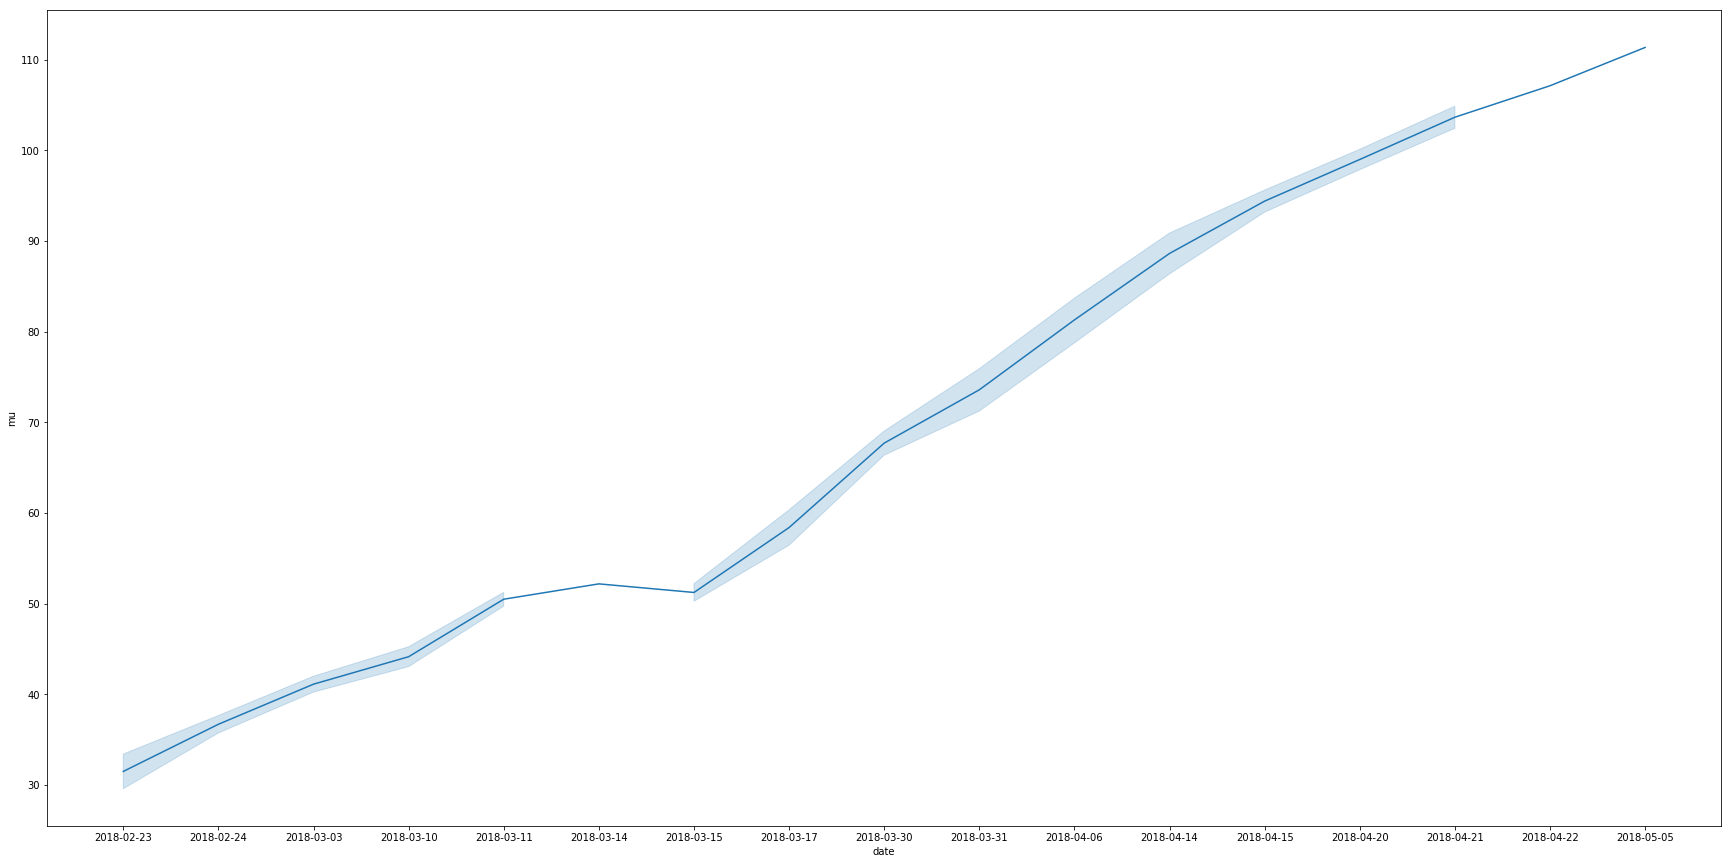

In [631]:
def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    
    temp_df['opponent_result'] = abs(temp_df.result - 1)
    
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    
    df_opp = pd.merge(df[['name', 'mu' ,'compID', 'position', 'result']], \
                       temp_df[['compID', 'position', 'opponent_result']], 
                       left_on=['compID', 'position', 'result'], 
                       right_on=['compID', 'position', 'opponent_result']) \
                .groupby(['compID'])
    
    df_opp1 = df_opp.first().reset_index()[['compID','name', 'mu']]
    df_opp1['Opponent 1'] = df_opp1['name']+' '+df_opp1['mu'].apply(lambda x: '('+str(x)+ ')')
    df_opp2 = df_opp.last().reset_index()[['compID','name', 'mu']]
    df_opp2['Opponent 2'] = df_opp2['name']+' '+df_opp2['mu'].apply(lambda x: '('+str(x)+ ')')
    
    opp = pd.concat([df_opp1, df_opp2], axis=1)
    opp.columns = ['compID', 'name', 'mu', 'Opponent 1', 'compID1', 'name', 'mu','Opponent 2']
    opp = opp[['compID', 'Opponent 1', 'Opponent 2']]
    
    df_summary = pd.merge(df_summary,opp, on='compID')
    df_summary = df_summary[['date', 'compID', 'location', 'first_name', 'last_name', 'name', \
       'position', 'primary position', 'college', 'division', 'result', \
       'mu', 'sigma', 'Partner', 'Opponent 1', 'Opponent 2']] 
    
    return df_summary

a = 'Katie Horton'
get_player_rating_history(d['match_history'], a)

# Enter the name of a player to get their rating history

Rachel Nieto
RACHEL NIETO
College: Long Beach State
Division: DI
Primary Position: 2
Last Rating:116.46580356230518


/usr/local/anaconda3/envs/Conda3/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma,Partner,Opponent 1,Opponent 2
0,2018-03-04,982,"Northridge, Ca",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,1,31.102733,7.745805,Nele Barber (31.102732927),Emily Hansen (25.0476665957),Sydney Haynes (25.0476665957)
1,2018-03-04,983,"Northridge, CA",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,1,35.547855,7.397322,Nele Barber (35.5478553162),Aeryn Owens (26.2194894717),Katie Sato (26.2194894717)
2,2018-03-06,993,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,0,38.000813,7.215549,Nele Barber (38.0008134716),Natalie Anselmo (51.3723293741),Olivia Macdonald (51.3723293741)
3,2018-03-07,1000,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,0,40.497653,7.027924,Nele Barber (40.4976529704),Brook Bauer (53.0783690214),Madalyn Roh (53.0783690214)
4,2018-03-12,1081,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,1,43.827319,6.898237,Nele Barber (43.8273192605),Taylor Fricano (29.2847003455),Veronica Snelling (29.2847003455)
5,2018-03-15,1102,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,2,2,Long Beach State,DI,0,43.089938,6.373305,Nele Barber (43.0899382221),Haven Hill (46.8399213181),Cassie House (46.8399213181)
6,2018-03-15,1105,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,2,2,Long Beach State,DI,1,51.689517,5.769054,Nele Barber (51.6895171814),Macy Jerger (58.5791981442),Brooke Kuhlman (49.0250775202)
7,2018-03-22,1225,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,2,2,Long Beach State,DI,1,54.420625,5.638199,Nele Barber (54.4206250512),Destiny Julye (43.6314470578),Courtney Schwan (43.6314470578)
8,2018-03-23,1230,"Irvine, Ca",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,1,61.331937,5.258406,Nele Barber (61.3319368204),Lauren Stivrins (62.8901062818),Kelly Hunter (60.6897431116)
9,2018-03-27,1331,"Long Beach, Ca",Rachel,Nieto,Rachel Nieto,1,2,Long Beach State,DI,1,69.824512,4.860173,Nele Barber (69.8245118993),Kathryn Plummer (70.1840614099),Sunny Villapando (77.8402812291)


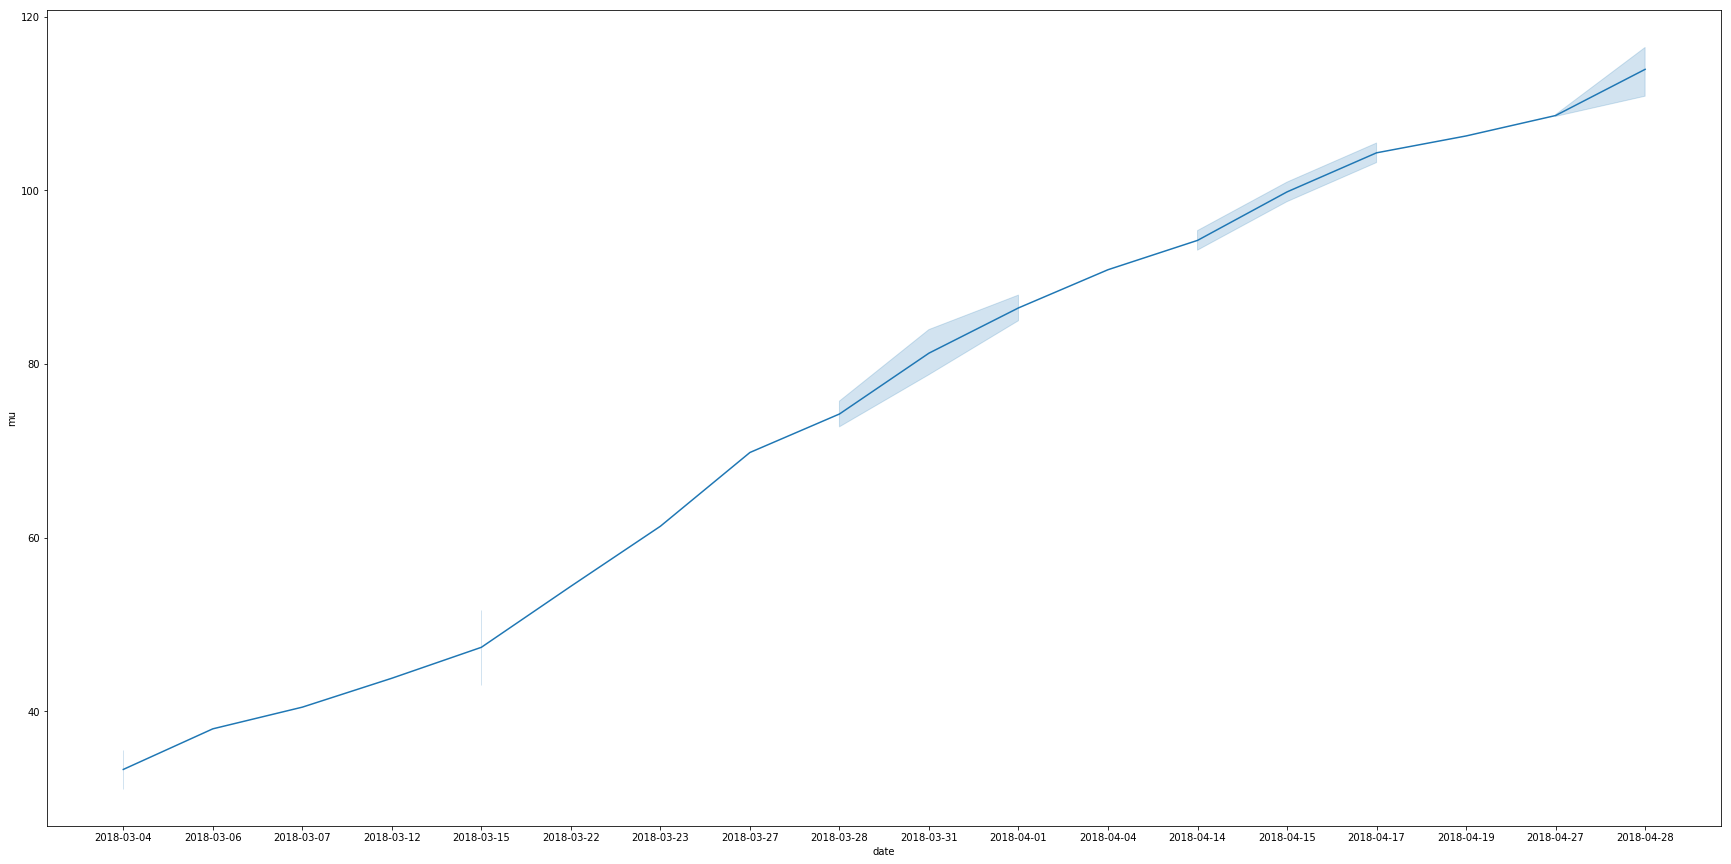

In [637]:
a = raw_input()
get_player_rating_history(d['match_history'], a) #.to_csv('Katie Horton.csv')

# Matchups -  Probability of wins

In [532]:
def predict_match(compid_, df_):
    r = {}
    v = {}
    t = {}
    
    match = df_[df_['compID'].astype(int) == compid_]
    counter = 0
    grouped = match.groupby(['date', 'compID', 'position'])
    
    for k in grouped.groups.keys():
        df_temp = grouped.get_group(k)
        df_temp = df_temp.sort_values('result', ascending=True)
        
        
        Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
        
        t1 = df_temp.head(2)
        
        #t[1] = [r[1], r[2]]
        #t[2] = [r[3], r[4]]
        
        #win_prob = win_probability(t[1], t[2])
    
    return df_temp.head(2)

matches = d['match_history']
predict_match(800, matches)

,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma
74,2018-02-23,800,"Deland, FL",Ali,Denney,Ali Denney,1,1,South Carolina,DI,1,29.508323,7.774363
107,2018-02-23,800,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,29.508323,7.774363


In [ ]:
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5

In [ ]:




    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

In [454]:
def win_probability(team1_, team2_):
    delta_mu = sum(r.mu for r in team1_) - sum(r.mu for r in team2_)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1_, team2_))
    size = len(team1_) + len(team2_)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = global_env()
    return ts.cdf(delta_mu / denom)

matches = d['match_history']
matches[(matches.compID == 800) & (matches.position == 1)]

,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma
0,2018-02-23,800,"Deland, FL",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,0,23.291677,7.774363
37,2018-02-23,800,"Deland, FL",Brooke,Weiner,Brooke Weiner,1,2,Georgia State,DI,0,23.291677,7.774363
74,2018-02-23,800,"Deland, FL",Ali,Denney,Ali Denney,1,1,South Carolina,DI,1,29.508323,7.774363
107,2018-02-23,800,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,29.508323,7.774363


In [ ]:


def actual_match(compid_, df_):
    return df_[df_['Compid'].astype(int) == compid_].groupby('Winner')['Position'].count()

actual_match(1863, df_matchups)

def predict_match(compid, df):
    match = df[df['Compid'].astype(int) == compid].copy().reset_index().iloc[:,1:]
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
            #match[i] = r[i]
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5
        
    
    return match

_df = {}
temp = None
for a in range(780, 1870):
    print a,
    _df = predict_match(a, df_matchups)
    _df = pd.concat([_df, temp], axis=0)
    temp = _df


total_no_draw = len(_df[_df['Winner'] != 'Draw'])
accurate = len(_df[_df['Winner'] == _df['Predicted Winner']])
print accurate, total_no_draw, accurate*100/total_no_draw

_df



In [ ]:
# Predict a Match

ef predictMatch(_compid, _df):
    _match = df_all_matchups[df_all_matchups['CompID'] == _compid].iloc[:,0:5]
    wins = {}

    for i in range(0,len(_match)):
        r = [Rating(lookupPlayerRating(_match.iloc[i,j], predict_ranking))  for j in range(1,5)]

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        win_prob = win_probability(t1, t2)

        #print [(_match.iloc[i,j]+"("+lookupPlayer(_match.iloc[i,j], _df)['Team']+")") for j in range(1,5) ],

        if win_prob > .50:
            val = max(lookupPlayer(_match.iloc[i, 1], _df)['Team'], lookupPlayer(_match.iloc[i, 2], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        elif win_prob < .50:
            val = max(lookupPlayer(_match.iloc[i, 3], _df)['Team'], lookupPlayer(_match.iloc[i, 4], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        else:
            val = 'Draw'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
                
    match_winner = max(wins.iteritems(), key=operator.itemgetter(1))[0]      
    
    return wins, match_winner

print "Predicted:" + str(predictMatch(1816, df_player_ratings))
print "Actual:" + str(actualMatch(1816, df_player_ratings))